Computer Exercise 2

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2

# This .mat file should contain:
# - x: a Python list or array with matched points for each image, e.g. x[0] -> 2xN, x[1] -> 2xN
# - K: the camera calibration matrix (3x3), same for both images

data = sio.loadmat('compEx2data.mat')
x_data = data['x']  # shape or structure might vary
K = data['K']       # shape (3,3)
print(x_data)
# Typically, x_data might be something like:
# x_data[0,0] -> 2 x N (image1), x_data[0,1] -> 2 x N (image2)
# We need to adapt indexing to the actual structure.

# For demonstration, let's assume:
x1 = x_data[0,0]  # 2 x N in image 1
x2 = x_data[0,1]  # 2 x N in image 2
N = x1.shape[1]
print(f'Number of matched points: {N}')
print('K =\n', K)
scale_x = K[0, 0]
scale_y = K[1, 1]

print(f"Scale X: {scale_x:.2f}, Scale Y: {scale_y:.2f}")


[[array([[1647.86,  798.78, 1691.72, ...,  672.04,  900.02, 1011.28],
         [ 495.86,  387.94,  473.16, ...,   13.22,   11.32,   10.36]])
  array([[1806.12,  810.98, 1855.96, ...,  692.62,  927.82, 1051.92],
         [ 588.84,  468.38,  563.16, ...,   75.66,   65.74,   63.9 ]])]]
Number of matched points: 1472
K =
 [[2.39395217e+03 0.00000000e+00 9.32382177e+02]
 [0.00000000e+00 2.39811854e+03 6.28264995e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Scale X: 2393.95, Scale Y: 2398.12


In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert to normalized coordinates
x1_h = np.vstack((x1, np.ones((1, N))))
x2_h = np.vstack((x2, np.ones((1, N))))
K_inv = np.linalg.inv(K)
x1n = K_inv @ x1_h
x2n = K_inv @ x2_h

# Five-point solver
def fivepoint_solver(x1n_5, x2n_5):
    M = np.zeros((5, 9))
    for i in range(5):
        xx = np.outer(x2n_5[:, i], x1n_5[:, i])
        M[i, :] = xx.flatten()

    def null_space(A, rtol=1e-6):
        U, S, Vt = np.linalg.svd(A, full_matrices=True)
        rank = (S > rtol * S[0]).sum()
        return Vt[rank:].T.copy()

    Evec = null_space(M)
    Esol = [Evec[:, i].reshape((3, 3)).T for i in range(4)]
    return Esol

# Inlier function
def is_inlier(E, x1_px, x2_px, K, threshold=5.0):
    K_inv = np.linalg.inv(K)
    K_inv_T = np.linalg.inv(K.T)
    F = K_inv_T @ E @ K_inv
    
    l2 = F @ x1_px
    dist2 = abs(x2_px.T @ l2) / np.sqrt(l2[0]**2 + l2[1]**2)

    l1 = F.T @ x2_px
    dist1 = abs(x1_px.T @ l1) / np.sqrt(l1[0]**2 + l1[1]**2)

    return (dist1 < threshold) and (dist2 < threshold)



In [7]:
##############################################
# RANSAC
##############################################

num_iterations = 200  # suggested at least 100
best_inliers = 0
best_E = None

idx_all = np.arange(N)

for _ in range(num_iterations):
    # 1) Randomly pick 5 distinct indices
    subset = np.random.choice(idx_all, 5, replace=False)
    x1n_5 = x1n[:, subset]
    x2n_5 = x2n[:, subset]

    # 2) Solve for E
    E_candidates = fivepoint_solver(x1n_5, x2n_5)

    # 3) For each candidate E, count inliers
    for E_test in E_candidates:
        inliers_count = 0
        for i in range(N):
            x1_px = x1_h[:, i]
            x2_px = x2_h[:, i]
            if is_inlier(E_test, x1_px, x2_px, K=K, threshold=5.0):
                inliers_count += 1

        if inliers_count > best_inliers:
            best_inliers = inliers_count
            best_E = E_test

print(f'Best inliers = {best_inliers} / {N}')

Best inliers = 221 / 1472


1472
Best decomposition has 1472 points in front of both cameras.


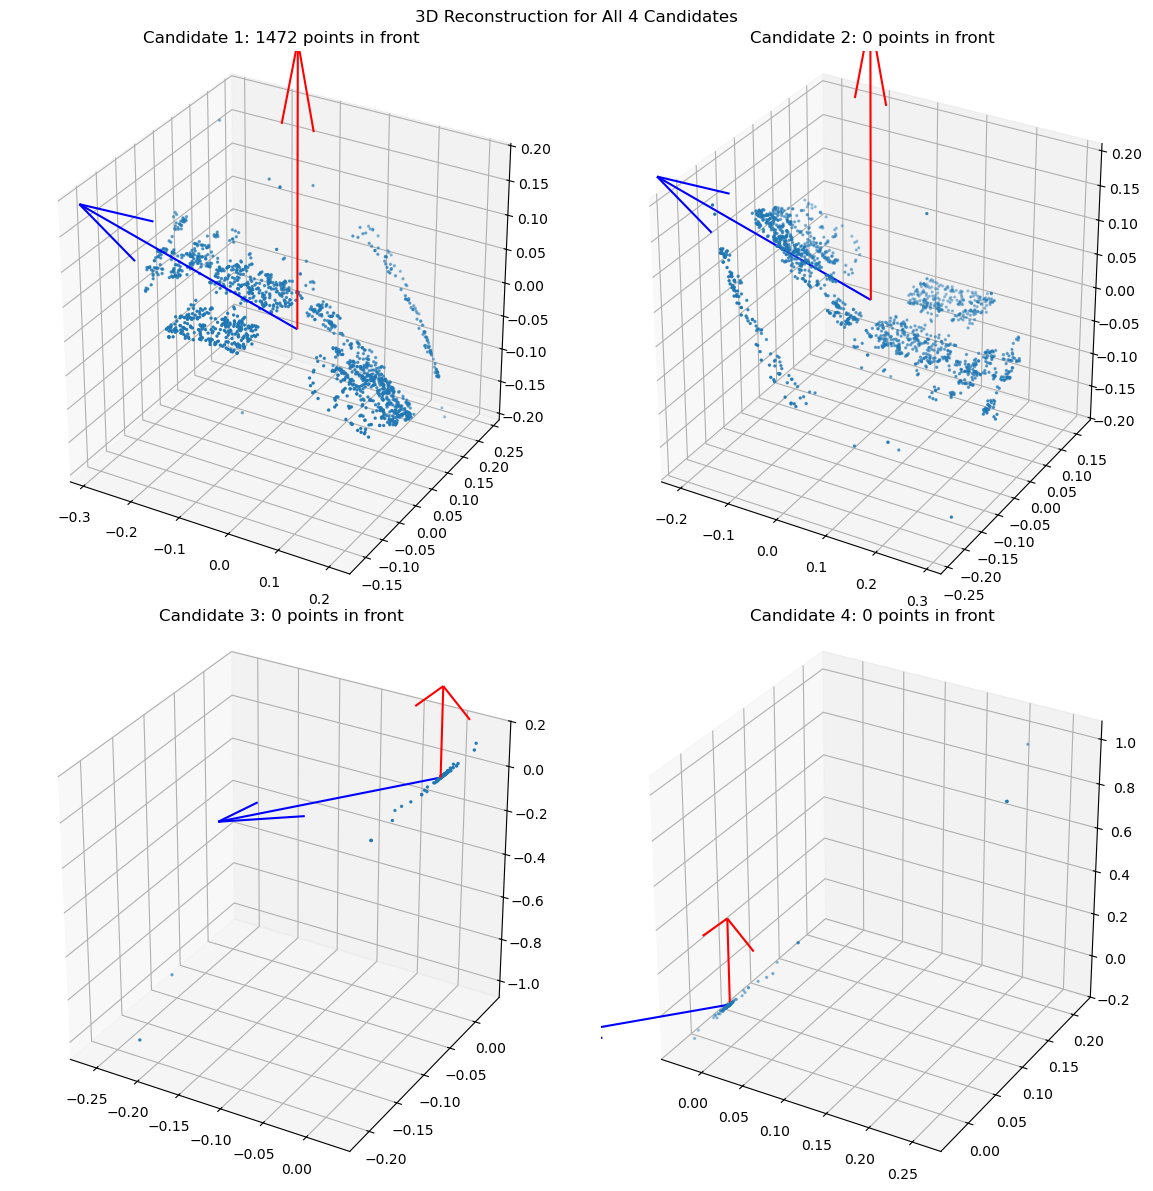

In [28]:
# Essential Matrix Decomposition
U, S, Vt = np.linalg.svd(best_E)
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]], dtype=float)

R1 = U @ W @ Vt
R2 = U @ W.T @ Vt
R1 = R1 if np.linalg.det(R1) > 0 else -R1
R2 = R2 if np.linalg.det(R2) > 0 else -R2

t = U[:, 2]

candidates = [(R1, t), (R1, -t), (R2, t), (R2, -t)]

# Inlier Mask
if 'inlier_mask' not in locals():
    inlier_mask = np.ones(x1_h.shape[1], dtype=bool)

inlier_indices = np.where(inlier_mask)[0]
x1_in = x1_h[:, inlier_indices]
x2_in = x2_h[:, inlier_indices]
print(len(x1_in[0]))

# Visualization setup
fig = plt.figure(figsize=(12, 12))
best_count = -1
best_3D = None
for idx, (R, t) in enumerate(candidates):
    P1 = np.hstack([np.eye(3), np.zeros((3, 1))])
    P2 = np.hstack([R, t.reshape((3, 1))])

    P1_pixel = K @ P1
    P2_pixel = K @ P2
 

    X_3D = cv2.triangulatePoints(P1_pixel, P2_pixel, x1_in[:2], x2_in[:2])
    X_3D /= X_3D[3, :]
    front1 = X_3D[2, :] > 0 
    front2 = (R @ X_3D[:3, :] + t.reshape(3, 1))[2, :] > 0
    valid = np.logical_and(front1, front2)
    count_in_front = np.sum(valid)

    if count_in_front > best_count:
        best_count = count_in_front
        best_3D = X_3D

    # Normalize for visualization
    X_3D[:3, :] /= np.max(np.abs(X_3D[:3, :]))
    center = np.mean(X_3D[:3, :], axis=1, keepdims=True)
    X_3D_centered = X_3D[:3, :] - center

    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
    ax.scatter(X_3D_centered[0, :], X_3D_centered[1, :], X_3D_centered[2, :], s=2)
    scale = 0.4
    ax.quiver(0, 0, 0, 0, 0, scale, color='r', label='Camera 1 Principal Axis')
    ax.quiver(0, 0, 0, scale * R[0, 2], scale * R[1, 2], scale * R[2, 2], color='b', label='Camera 2 Principal Axis')
    ax.set_box_aspect([1, 1, 1])
    ax.set_title(f"Candidate {idx + 1}: {count_in_front} points in front")

print(f'Best decomposition has {best_count} points in front of both cameras.')

plt.suptitle("3D Reconstruction for All 4 Candidates")
plt.tight_layout()
plt.show()


[[1474.41286913  687.88735408 1520.00995693 ...  557.19273439
   759.55918188  861.66449122]
 [ 707.73389272  489.97463154  690.38812514 ...  135.12325122
   169.41973216  185.16039394]]
[[1647.86  798.78 1691.72 ...  672.04  900.02 1011.28]
 [ 495.86  387.94  473.16 ...   13.22   11.32   10.36]]
///////////////
[[4347.88775455 4921.30544168 4357.24962664 ... 5704.61034544
  5446.63943157 5335.00521557]
 [1644.31739529 2262.62273909 1609.97340413 ... 2426.87755961
  2178.2609839  2064.52131228]]
[[1806.12  810.98 1855.96 ...  692.62  927.82 1051.92]
 [ 588.84  468.38  563.16 ...   75.66   65.74   63.9 ]]
///////////////
RMS Error - Camera 2: 3954.93 px
RMS Error - Camera 1: 225.04 px


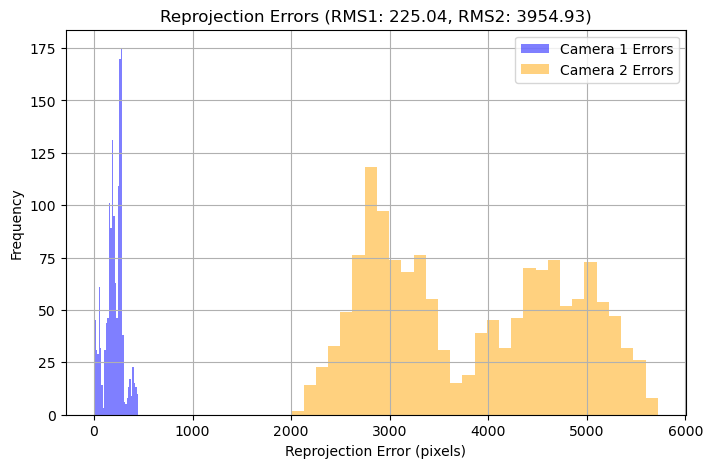

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Compute Reprojection Error ---
def compute_reprojection_error(P, X_3D, x):
    """Compute reprojection errors for all inlier points"""

    # Project 3D points into the camera
    X_proj = P @ X_3D
    X_proj /= X_proj[2]  # Normalize
    X_proj = X_proj[:2]  # Drop the third coordinate
    print(X_proj)
    print(x[:2])
    print('///////////////')
       

    # Compute Euclidean distance (error per point)
    return np.linalg.norm(X_proj - x[:2], axis=0)

# --- Compute RMS Error ---
def compute_rms_error(errors):
    """Compute RMS error"""
    return np.sqrt(np.mean(errors**2))
# --- Scale Triangulated Points ---
# --- Compute Errors ---
errors1 = compute_reprojection_error(P1_pixel, best_3D, x1_in)
errors2 = compute_reprojection_error(P2_pixel, best_3D, x2_in)
# --- Compute RMS ---
rms_error_1 = compute_rms_error(errors1)
rms_error_2 = compute_rms_error(errors2)

print(f"RMS Error - Camera 2: {rms_error_2:.2f} px")
print(f"RMS Error - Camera 1: {rms_error_1:.2f} px")


# --- Plot Histogram ---
plt.figure(figsize=(8, 5))
plt.hist(errors1, bins=30, alpha=0.5, label='Camera 1 Errors', color='blue')
plt.hist(errors2, bins=30, alpha=0.5, label='Camera 2 Errors', color='orange')

plt.title(f"Reprojection Errors (RMS1: {rms_error_1:.2f}, RMS2: {rms_error_2:.2f})")
plt.xlabel("Reprojection Error (pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'compute_camera_candidates' is not defined